## Hidden Hypoxemia Classification using RandomUnderSampling and Ensemble of XGBoost Classifiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

Cleaning the data to remove errroneous SpO2/SaO2 values : Biologically, patients cannot have a blood oxygen concentration of less than 70%

In [2]:
seed = 42
df = pd.read_csv('../data/mimic_pulseOx_data.csv')
pd.options.display.max_columns = df.shape[1]

#removing unphysical SpO2 values, and removing the 12 people with NaN for 'heart_rhythm',
df = df[(df['SaO2'] <= 100) & (df['SpO2'] <= 100) & (df['SaO2'] >= 70) & (df['SpO2'] >= 70)&df['heart_rhythm'].notna()].copy()
#we are trying to classify
print(df.shape)

## NEW: For people with race_group = 'Other' but race = 'UNKNOWN', change race_group to 'Unknown'
## (Because Unknown race is different from 'Other' race)
## Do the same for race = 'PATIENT DECLINED TO ANSWER' and 'UNABLE TO OBTAIN'
### First add 'Unknown' as a category
df['race_group'] = df['race_group'].copy().astype('category')
df['race_group'] = df.race_group.cat.add_categories(new_categories = 'Unknown')
### Then do the replacements
df.race_group.loc[df.race == 'UNKNOWN'] = 'Unknown'
df.race_group.loc[df.race == 'PATIENT DECLINED TO ANSWER'] = 'Unknown'
df.race_group.loc[df.race == 'UNABLE TO OBTAIN'] = 'Unknown'
## Also make sure those coded as multiracial get the 'Other' label
df.race_group.loc[df.race == 'MULTIPLE RACE/ETHNICITY'] = 'Other'


(81150, 138)


Defining feature sets and imputing NaN values using IterativeImputer 

In [3]:
cont_features = ['SpO2','anchor_age','weight','height','BMI','heart_rate', 'mbp','resp_rate','temperature']
normalizable_cont_features = ['SpO2','anchor_age','weight','height','BMI','heart_rate' , 'mbp','resp_rate','temperature']
cat_features = [ 'gender', 'race_group', 'heart_rhythm']

## Feature set for online, smaller model
# cont_features = ['SpO2','anchor_age','weight','height','temperature']
# normalizable_cont_features = ['SpO2','anchor_age','weight','height','temperature']
# cat_features = [ 'gender', 'race_group']
df[cat_features] = df[cat_features].copy().astype('category')

#normalizing all continuous variables by maximum value. Comment out the for loop if you don't want to normalize. 
for string in normalizable_cont_features:
    df[string] = df[string].astype(float)/(df[string].astype(float).max())


imputed_df = df.copy()
imp = IterativeImputer(max_iter = 20, random_state=seed)
imputed_df[cont_features] = imp.fit_transform(imputed_df[cont_features])

c:\Users\jaych\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Train Test Split

In [4]:
df_train_valid, df_test = train_test_split(imputed_df.copy(), stratify=imputed_df.copy()['hidden_hypoxemia'], test_size = 0.2, random_state=seed)
df_train, df_valid = train_test_split(df_train_valid.copy(), stratify=df_train_valid.copy()['hidden_hypoxemia'], test_size = 0.05, random_state=seed)

## Training Cycle

Make an ensemble of XGBClassifiers with the same hyperparameters, and train on random subsets of data (stratified by Hidden Hypoxemia)

Random Undersampling has been implemented to counter both the overrepresentation of the majority class (hidden_hypoxemia = 0, 98% of dataset) 

and majority race_group (white, 60% of dataset)

In [5]:

base_classifiers = []
num_estimators = 35
minority_to_majority_ratio = 0.5
drop_whites = 0.1

for i in range(num_estimators):
    if i%10 == 0:
        print("Training Estimator #", i)
    base_classifier = xgboost.XGBClassifier(tree_method = 'approx',
                                 enable_categorical=True,
                                 learning_rate=.1,
                                 max_depth=3,
                                 n_estimators=50,
                                 early_stopping_rounds = 25, 
                                 scale_pos_weight = int(1/minority_to_majority_ratio)
                                 )
    
    white_indices = df_train.index[df_train['race_group']=='White']
    if (drop_whites == 0):
        df_train_dropped = df_train.copy()
    else:
        to_drop = np.random.choice(white_indices, size=int(drop_whites*len(white_indices)), replace = False)
        df_train_dropped = df_train.copy().drop(to_drop)

    rus = RandomUnderSampler(sampling_strategy=minority_to_majority_ratio)
    X_train_resampled, y_train_resampled = rus.fit_resample(df_train_dropped[cont_features + cat_features], df_train_dropped['hidden_hypoxemia'])


    base_classifier.fit(X_train_resampled, y_train_resampled, 
                        eval_set = [(df_valid[cont_features + cat_features],df_valid['hidden_hypoxemia'])], 
                        verbose=50)
    base_classifiers.append(base_classifier)
    del rus
    del X_train_resampled, y_train_resampled, df_train_dropped
    


Training Estimator # 0
[0]	validation_0-logloss:0.66839
[49]	validation_0-logloss:0.50487
[0]	validation_0-logloss:0.66883
[49]	validation_0-logloss:0.50563
[0]	validation_0-logloss:0.66738
[49]	validation_0-logloss:0.50013
[0]	validation_0-logloss:0.66714
[49]	validation_0-logloss:0.49932
[0]	validation_0-logloss:0.66802
[49]	validation_0-logloss:0.50457
[0]	validation_0-logloss:0.66700
[49]	validation_0-logloss:0.50406
[0]	validation_0-logloss:0.66728
[49]	validation_0-logloss:0.49836
[0]	validation_0-logloss:0.66748
[49]	validation_0-logloss:0.50113
[0]	validation_0-logloss:0.66709
[49]	validation_0-logloss:0.49758
[0]	validation_0-logloss:0.66747
[49]	validation_0-logloss:0.50078
Training Estimator # 10
[0]	validation_0-logloss:0.66674
[49]	validation_0-logloss:0.50153
[0]	validation_0-logloss:0.66813
[49]	validation_0-logloss:0.50088
[0]	validation_0-logloss:0.66653
[49]	validation_0-logloss:0.49408
[0]	validation_0-logloss:0.66743
[49]	validation_0-logloss:0.50619
[0]	validation_

## Testing cycle

Get the predictions from all the classifiers in the ensemble and average them

In [6]:
def ensemble_predict(classifier_list, df_predict, threshold): 
    cont_features = ['SpO2','anchor_age','weight','height','BMI','heart_rate', 'mbp','resp_rate','temperature']
    cat_features = [ 'gender', 'race_group', 'heart_rhythm']
    predictions_0 = []
    predictions_1 = []
    for classifier in classifier_list:
        y_pred_0 = classifier.predict_proba(df_predict[cont_features + cat_features])[:,0]
        y_pred_1 = classifier.predict_proba(df_predict[cont_features + cat_features])[:,1]
        predictions_0.append(y_pred_0)
        predictions_1.append(y_pred_1)
    predictions_0= np.array(predictions_0)
    predictions_1 = np.array(predictions_1)
    averaged_predictions_1 = list(pd.DataFrame(predictions_1).mean(axis=0))
    ensemble_predicts = [1 if pred >= threshold else 0 for pred in averaged_predictions_1]
    return ensemble_predicts,  averaged_predictions_1

# del ensemble_predictions
ensemble_predictions, probabilities = ensemble_predict(base_classifiers, df_test, 0.5)
print('Accuracy: ', round(accuracy_score(df_test['hidden_hypoxemia'], ensemble_predictions), 2))

Accuracy:  0.82


The vanilla accuracy score is not good enough: We could've gotten 98% accuracy by just predicting everyone as not having hidden hypoxemia

Instead, we calculate other accuracy scores: Sensitivity and Specificity

<b>Sensitivity</b> is the probability that an individual with Hidden Hypoxemia is correctly identified as such

<b>Specificity</b> is the probability that a healthy individual is correctly identified as such

In [8]:
def get_sensitivity(df, feature, predictions, verbosity=1):
    num_sick = np.inner(df[feature].values, df[feature].values)
    sensitivity = np.inner(predictions,(df[feature].values))/num_sick
    if verbosity > 0:
        print("Sensitivity = " + str(round(sensitivity*100, 2)) + " %")
    return sensitivity

def get_specificity(df, feature, predictions, verbosity = 1):
    num_healthy = np.inner(1-  df[feature].values, 1-  df[feature].values)
    specificity = np.inner(1 - np.array(predictions), 1 -  df[feature].values)/num_healthy
    if verbosity > 0:
        print("Specificity = ", round(specificity*100, 2), "%")
    return specificity

print("Proportion of people predicted to have HH: ")
print(pd.DataFrame(ensemble_predictions).value_counts()[1]/len(ensemble_predictions))
sensitivity = get_sensitivity(df_test, 'hidden_hypoxemia', ensemble_predictions)
specificity = get_specificity(df_test, "hidden_hypoxemia", ensemble_predictions)

Proportion of people predicted to have HH: 
0.18502772643253235
Sensitivity = 67.82 %
Specificity =  82.3 %


Another good statistic to evaluate the overall usefulness of the model is <b>Youden's J-index</b>

Youden's J-index = sensitivity + specificity - 1

Random Classifiers will score 0 on this index, a perfect test will score 1. A test is deemed "useful" in medical testing if this score is atleast 0.5

In [9]:
J_Index = specificity + sensitivity - 1
print('Youden\'s J-Index: ', round(J_Index, 3) )

Youden's J-Index:  0.501


### What is the ensemble looking at the most to identify hidden hypoxemia? 

Look at averaged feature importances for the ensemble: SpO2 is obviously the most important feature

Text(0.5, 0, 'Ensemble Averaged Feature Importance')

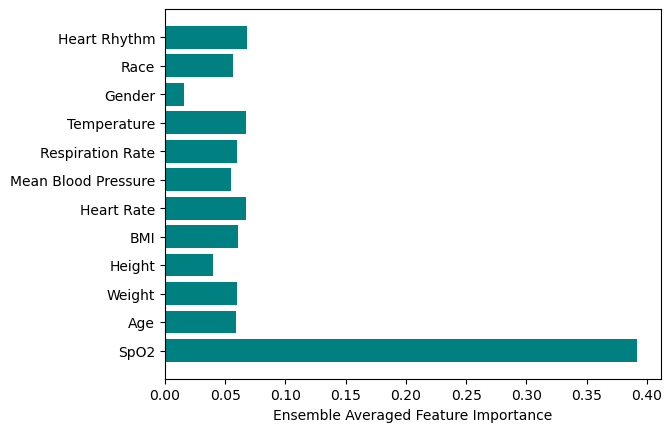

In [10]:
feature_names = ['SpO2', 'Age', 'Weight', 'Height', 'BMI', 'Heart Rate',
                  'Mean Blood Pressure', 'Respiration Rate', 'Temperature', 'Gender', 'Race', 'Heart Rhythm']
# feature_names = ['SpO2', 'Age', 'Weight', 'Height', 'Temperature', 'Gender', 'Race']
ensemble_importances = []
for base_classifier in base_classifiers:
    ensemble_importances.append(base_classifier.feature_importances_)
averaged_importances = list(pd.DataFrame(ensemble_importances).mean(axis = 0))

plt.barh(feature_names, averaged_importances, color='Teal')
plt.xlabel("Ensemble Averaged Feature Importance")

### How does accuracy scores differ by race_group? 

Here, we stratify the test dataset by race_group and calculate the accuracy scores to see if our model performs differently for persons with darker skin pigmentation

In [11]:
sens_by_race = []
spec_by_race = []
race_group_list = list(df_test.race_group.unique())
for race in race_group_list:
    print("Race: ", race)
    df_temp = df_test[df_test['race_group'] == race]
    group_predictions, probabilities = ensemble_predict(base_classifiers, df_temp, 0.5)
    sens_by_race.append(get_sensitivity(df_temp, 'hidden_hypoxemia', group_predictions))
    spec_by_race.append(get_specificity(df_temp, 'hidden_hypoxemia', group_predictions))

Race:  Other
Sensitivity = 53.85 %
Specificity =  83.59 %
Race:  Unknown
Sensitivity = 75.0 %
Specificity =  81.93 %
Race:  Black
Sensitivity = 74.36 %
Specificity =  78.19 %
Race:  White
Sensitivity = 64.79 %
Specificity =  82.86 %
Race:  Hispanic
Sensitivity = 69.23 %
Specificity =  83.82 %
Race:  Asian
Sensitivity = 66.67 %
Specificity =  76.87 %


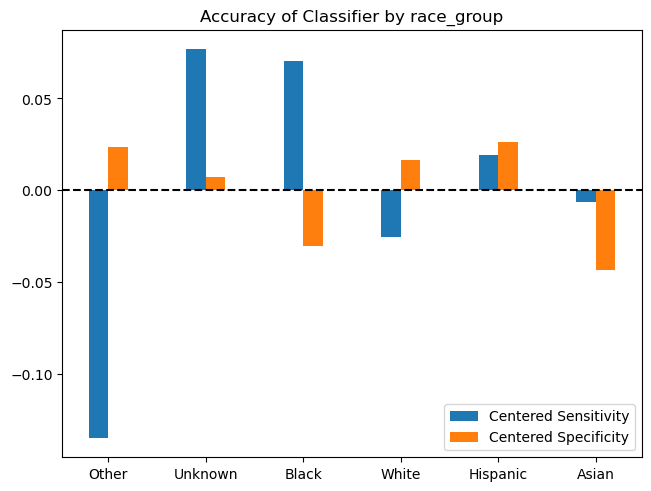

In [12]:
x = np.arange(len(race_group_list))  # the label locations
width = 0.2
fig, ax = plt.subplots(layout='constrained')
ax.bar(x - 0.1, np.array(sens_by_race) - np.mean(sens_by_race), width, label='Centered Sensitivity')
ax.bar(x + 0.1, np.array(spec_by_race) - np.mean(spec_by_race), width, label='Centered Specificity')
plt.axhline(y=0.0, color='black', linestyle='--')
ax.set_xticks(x, race_group_list)
ax.set_title("Accuracy of Classifier by race_group")
# ax.set_ylim(0, 1)
ax.legend(loc='lower right')

We see that the model consistently performs better on Black and Hispanic patients

### How does the threshold for detection affect the accuracy measures?

We see that the sensitivity and specificity behave as expected. The J-index is highest around threshold = 0.5, so we stick to that for maximum sensitivity + specificity.

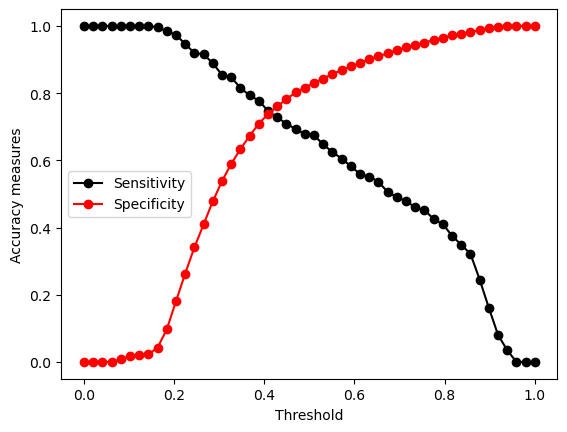

In [13]:
threshold_list = np.linspace(0,1,50)
sensitivity_list = []
specificity_list = []
for threshold in threshold_list:
    predictions, probabilities = ensemble_predict(base_classifiers, df_test, threshold)
    sensitivity_list.append(get_sensitivity(df_test, 'hidden_hypoxemia', predictions, verbosity = 0 ))
    specificity_list.append(get_specificity(df_test, 'hidden_hypoxemia', predictions, verbosity = 0))

plt.plot(threshold_list, sensitivity_list, '-o', color='black', label='Sensitivity')
plt.plot(threshold_list, specificity_list, '-o', color='red', label='Specificity')
plt.xlabel("Threshold")
plt.ylabel("Accuracy measures")
plt.legend()

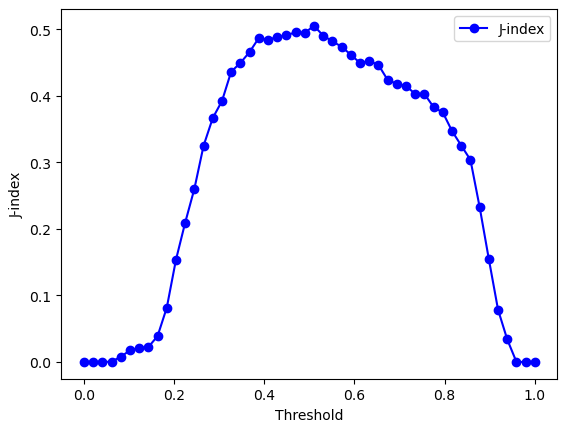

In [14]:
J_index_list = np.array(sensitivity_list) + np.array(specificity_list) - 1
plt.plot(threshold_list, J_index_list, '-o', color='blue', label='J-index')
plt.xlabel("Threshold")
plt.ylabel("J-index")
plt.legend()

### ROC Curve

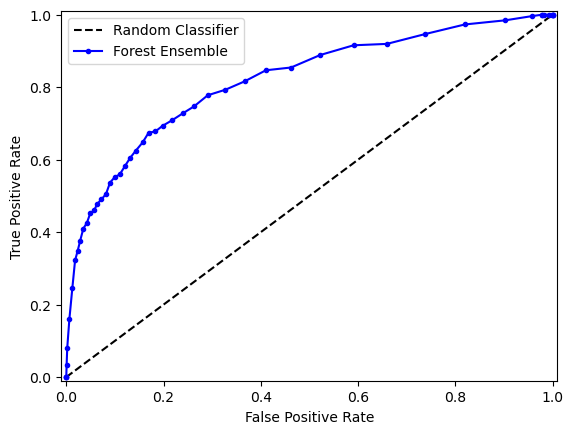

In [15]:
from sklearn.metrics import roc_curve

noskill_probs = [0 for _ in range(len(df_test['hidden_hypoxemia']))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(df_test['hidden_hypoxemia'], noskill_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='Black', label='Random Classifier')
plt.plot(1 - np.array(specificity_list), sensitivity_list, marker='.', color='blue',label='Forest Ensemble')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
# show the legend
plt.legend()

Code snippet to save an instance of the trained ensemble to a json file:

In [15]:
import json
import pickle

# Save models to a JSON file
model_data = []
for i, model in enumerate(base_classifiers):
    model_data.append({
        'index': i,
        'model': pickle.dumps(model).decode('latin1')
    })

with open('HH_ensemble_classifier_online.json', 'w') as file:
    json.dump(model_data, file)


Code snippet to load an ensemble from a saved model:

In [16]:
loaded_models = []
with open('HH_ensemble_classifier_online.json', 'r') as file:
    model_data = json.load(file)
    for item in model_data:
        index = item['index']
        model = pickle.loads(item['model'].encode('latin1'))
        loaded_models.append(model)